In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from seqeval.metrics import classification_report,accuracy_score,f1_score
from seqeval.scheme import IOB2

from dataload import lang, localdata
from tagger.charbilstm import CharBiLSTM
from etc.customUtil import showGraph, showParallel
from etc import defaultsetting as ds

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = ds.TOKKEN_PAD_IDX
tag_UNK = ds.TOKKEN_UNK_IDX

datasets, engdict, posdict = localdata.load_kor_ner(device, strmode=True) # , charmode=True)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

14096
1446
23
13
245
4
245
250
500
4250


In [5]:
def iteration(samples, optimizer, criterion):
    x_train, y_train = samples
        
    optimizer.zero_grad()

    o = model(engdict, device, x_train)
    o = o.view(-1,o.size(-1))
    t = y_train.view(-1)

    loss = criterion(o, t)
    loss.backward()
    optimizer.step()

    return loss.item()

In [6]:
def epoch(model, optimizer, criterion, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer, criterion)
        list_loss.append(loss)
    return list_loss

In [7]:
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        o = model(engdict, device, x_train)
        o = o.view(-1,o.size(-1))
        t = y_train.view(-1)

        total_loss += criterion(o, t).item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [8]:
def scores(model, dataset, batch_size):
    global engdict
    global posdict
    global device
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    
    y_train_true = []
    y_train_pred = []    
        
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(engdict, device, x_train)

        __tagged, tagged = torch.max(o, dim=-1)
        y_train = y_train.tolist()
        tagged = tagged.tolist()
        for i in range(len(y_train)):
            l = y_train[i]
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i][:seq_len]
            _p = tagged[i][:seq_len]

            if _y == _p:
                cnt_corr_samples +=1
            
            y_train_true.append(posdict.sentenceFromIndexes(_y))
            y_train_pred.append(posdict.sentenceFromIndexes(_p))
        
    return (cnt_corr_samples / total_samples,
            accuracy_score(y_train_true, y_train_pred),
            f1_score(y_train_true, y_train_pred, mode='strict', scheme=IOB2))

In [9]:
def train_losses_scores(model, optimizer, criterion, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []
                }
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]
                }
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=batch_size, shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, criterion, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, criterion, dataloader_dev))
        dict_losses['test'].append(evaluate(model, criterion, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])
        
        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_char_bilstm_ner.pt')
    print()
    return dict_losses, dict_scores

In [10]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(engdict, device, input_seq)
    __tagged, tagged = torch.max(o, dim=-1)
    return tagged

In [11]:
def calc(model, input_seq, target_seq=None):
    # input_seq = engdict.tensorFromSentence(input_seq, device)
    # input_list = engdict.sentenceFromIndexes(input_seq.tolist())
    input_list = input_seq.split()

    # print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, [input_seq]).view(-1).tolist())
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [12]:
# embedding_dim = 100
char_dim = 10
word_dim = 50
size_hidden = 50
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [13]:
model = CharBiLSTM(num_chars, num_words, char_dim, word_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, criterion, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

2 epoch Dev F1 score: 0.0 -> 0.0121581
3 epoch Dev F1 score: 0.0121581 -> 0.334975
4 epoch Dev F1 score: 0.334975 -> 0.432971
5 epoch Dev F1 score: 0.432971 -> 0.646617
6 epoch Dev F1 score: 0.646617 -> 0.713568
7 epoch Dev F1 score: 0.713568 -> 0.758735
8 epoch Dev F1 score: 0.758735 -> 0.766096
9 epoch Dev F1 score: 0.766096 -> 0.776392
11 epoch Dev F1 score: 0.776392 -> 0.781967
12 epoch Dev F1 score: 0.781967 -> 0.791633
13 epoch Dev F1 score: 0.791633 -> 0.799331
16 epoch Dev F1 score: 0.799331 -> 0.801287
19 epoch Dev F1 score: 0.801287 -> 0.806189
29 epoch Dev F1 score: 0.806189 -> 0.807325
36 epoch Dev F1 score: 0.807325 -> 0.8112
37 epoch Dev F1 score: 0.8112 -> 0.814696
49 epoch Dev F1 score: 0.814696 -> 0.815235
50 epoch Dev F1 score: 0.815235 -> 0.819063
60
	559.4539949893951


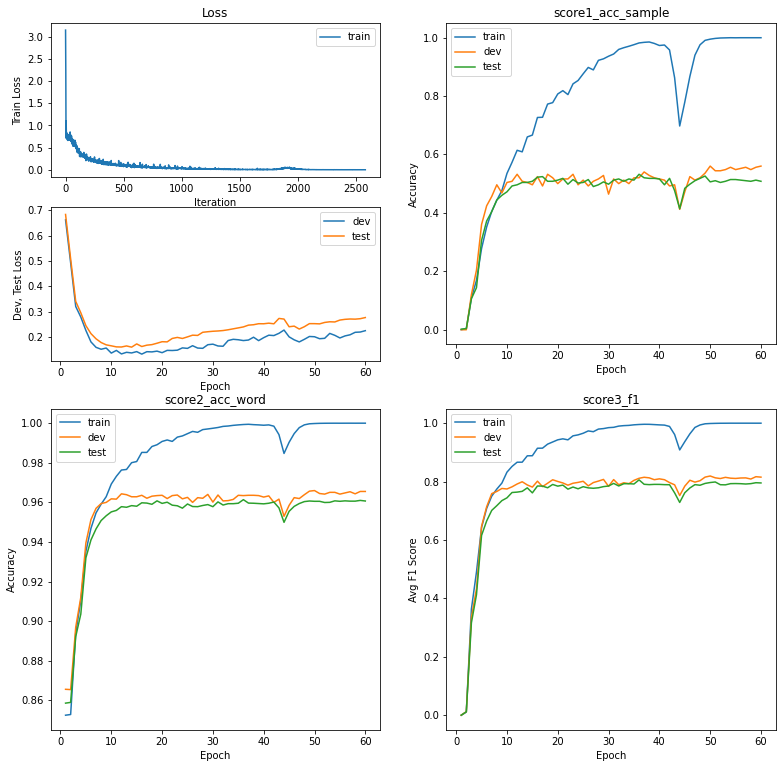

In [14]:
showGraph(dict_losses, dict_scores)

In [15]:
score_type=2
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.0   0.000   0.0
0.010664   0.01216   0.011817
0.36337   0.335   0.31629
0.49021   0.433   0.4125
0.64285   0.6466   0.61558
0.70799   0.7136   0.66501
0.75   0.7587   0.70122
0.77424   0.7661   0.71742
0.79467   0.7764   0.73468
0.8322   0.7746   0.74422
0.85182   0.782   0.76253
0.8662   0.7916   0.76387
0.86636   0.7993   0.76646
0.88815   0.7884   0.77845
0.88839   0.781   0.76124
0.91408   0.8013   0.78477
0.91436   0.7827   0.78447
0.92813   0.7943   0.77873
0.93553   0.8062   0.79008
0.94292   0.8003   0.78433
0.94632   0.7952   0.78783
0.94283   0.7876   0.77396
0.95658   0.7943   0.78124
0.95987   0.7971   0.77521
0.9654   0.801   0.78244
0.97337   0.7853   0.77839
0.97071   0.7965   0.77701
0.97968   0.8016   0.77866
0.98138   0.8073   0.78268
0.98461   0.7836   0.78479
0.9857   0.8067   0.79368
0.98989   0.7892   0.78488
0.99149   0.7959   0.79257
0.99233   0.7926   0.79272
0.99429   0.8042   0.79162
0.99541   0.8112   0.80573
0.99612   0.8147   0.79064
0.99597   0.8127   0

In [40]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 123
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
신지애                 B-PS    B-PS
의                   O       O
우승                  O       O
도전                  O       O
은                   O       O
SBS                 B-OG    B-OG
골프                  I-OG    I-OG
채널                  O       I-OG
을                   O       O
통해                  O       O
전국                  O       O
에                   O       O
생                   O       O
중계                  O       O
된다                  O       O
.                   O       O


In [17]:
# sen = 'I am your father .'
# # in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

# # sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
# #         4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
# #          116, 4616, 4617,   17]
# # in_sen = torch.tensor(sen2, device=device)

# calc(model, sen)

In [18]:
best_model = torch.load('best_char_bilstm_ner.pt')
s_dev = scores(best_model, datasets['dev'], 100)
s_test = scores(best_model, datasets['test'], 100)
print(s_dev)
print(s_test)

(0.56, 0.9659447348767737, 0.8190630048465267)
(0.506, 0.9605213591501545, 0.7966573816155988)
